In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import isodisreg 
from isodisreg import idr
from scipy import stats
import properscoring as ps
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from helper_functions import optimize_paras_onefit, llscore
from crpsmixture import smooth_crps
from tqdm import tqdm
import multiprocessing as mp
import itertools
from itertools import product
import time
import random
import h5py
#from helper_functions import ensemble_smoothing, llscore_ens_smoothing, crps_ens_smoothing

In [2]:
#Load indices
idx = {"u10":0, "v10":1, "t2m":2, "t850":3, "z500":4}
mean = np.load("../../data/stats_v0/global_means.npy").squeeze()
std = np.load("../../data/stats_v0/global_stds.npy").squeeze()

# Load Test data and FourCastnet predictions

In [3]:
# Open dataset
path_test = "../../data/predictions/ensemble_2022.h5"
test = xr.open_dataset(path_test)

y_test = test.ground_truth
x_single = test.predictions.isel(phony_dim_5 = 0)
x_ens = test.predictions.isel(phony_dim_5 = slice(1,51))

In [4]:
n_var = len(idx) + 1
length = y_test.shape[1]

In [5]:
# Create parallel pool
print("Number of processors: ", mp.cpu_count())

lat_range = y_test.shape[3]
lon_range = y_test.shape[4]

lat_lon_comb = [element for element in itertools.product(np.arange(lat_range), np.arange(lon_range))]
var_len_comb = list(product(np.arange(n_var), np.arange(length)))
n_proc = 22

Number of processors:  24


# Climatology model

In [ ]:
# Slicing of Era5 data
variables = np.array([0,1,2,5,14])
time_slice = np.arange(0,(365*4),4)
time_slice_gap = np.arange(0,(366*4),4)
#lat_slice = slice(60,220)
#lon_slice = np.append(np.arange(1390, 1440), np.arange(0, 170))

#Use old slices for beginning
lat_slice = slice(110,230)
lon_slice = np.append(np.arange(1370,1440), np.arange(0,60))

In [ ]:
#Load all data
era5_2018 = xr.open_dataset("../../data/out_of_sample/2018.h5").fields.isel(phony_dim_0 = time_slice, phony_dim_1 = variables, phony_dim_2 = lat_slice, phony_dim_3 = lon_slice)
era5_2019 = xr.open_dataset("../../data/out_of_sample/2019.h5").fields.isel(phony_dim_0 = time_slice, phony_dim_1 = variables, phony_dim_2 = lat_slice, phony_dim_3 = lon_slice)
era5_2020 = xr.open_dataset("../../data/out_of_sample/2020.h5").fields.isel(phony_dim_0 = time_slice_gap, phony_dim_1 = variables, phony_dim_2 = lat_slice, phony_dim_3 = lon_slice)
era5_2021 = xr.open_dataset("../../data/out_of_sample/2021.h5").fields.isel(phony_dim_0 = time_slice, phony_dim_1 = variables, phony_dim_2 = lat_slice, phony_dim_3 = lon_slice)

#Merge
climatology_data = xr.concat([era5_2018, era5_2019, era5_2020, era5_2021], dim = "phony_dim_0")

#Standardize
for j, var in enumerate(variables):
    climatology_data[:,j] = (climatology_data[:,j] - mean[var]) / std[var]

In [ ]:
#Define window
window = 15
n_pred = y_test.shape[0]
n_obs = climatology_data.shape[0]

In [ ]:
#Create output
clima_crps = np.zeros(shape = (n_var, lat_range, lon_range))
#Generate slices
for i in range(n_pred):    
    window_slice = np.arange(-window, window+1) + i
    clima_slice = np.append(window_slice, [(window_slice + 365), (window_slice + 2 * 365), (window_slice + 3*365+1)])
    clima_slice = clima_slice[(clima_slice >= 0) & (clima_slice < n_obs)]
    #CRPS for normal variables
    truth = y_test.isel(phony_dim_0 = i, phony_dim_1 = 0)
    pred = climatology_data.isel(phony_dim_0 = clima_slice).transpose(..., "phony_dim_0")
    crps = ps.crps_ensemble(truth, pred)
        
    #CRPS for wind speed
    true_wind = np.sqrt(np.power(truth.isel(phony_dim_2 = 0),2) + np.power(truth.isel(phony_dim_2 = 1),2))
    pred_wind = np.sqrt(np.power(pred.isel(phony_dim_1 = 0),2) + np.power(pred.isel(phony_dim_1 = 1),2))
    crps_wind = ps.crps_ensemble(true_wind, pred_wind)
    clima_crps += np.append(crps, np.expand_dims(crps_wind, axis = 0), axis = 0)
clima_crps = clima_crps / n_pred

f = h5py.File(f'crps_metrics.h5', 'a')
try:
    f.create_dataset(name = "climatology", data = clima_crps, shape = (n_var, lat_range, lon_range), dtype = np.float32)
except:
    del f["climatology"]
    f.create_dataset(name = "climatology", data = clima_crps, shape = (n_var, lat_range, lon_range), dtype = np.float32)
f.close()

# Evaluate Forecasts

In [ ]:
f = h5py.File(f'crps_metrics.h5', 'a')

try:
    f_ens_fc = f.create_dataset(name = "ens_fc", shape = (length, n_var, lat_range, lon_range), dtype = np.float32)
except:
    del f["ens_fc"]
    f_ens_fc = f.create_dataset(name = "ens_fc",  shape = (length, n_var, lat_range, lon_range), dtype = np.float32)

for step in range(length):    
    #Ensemble crps for normal variables
    truth = y_test.isel(phony_dim_1 = step)
    pred = x_ens.isel(phony_dim_1 = step).transpose(..., "phony_dim_5")
    crps_ens = np.mean(ps.crps_ensemble(truth, pred), axis = 0)
    
    #Ensemble crps for wind speed
    true_wind = np.sqrt(np.power(truth.isel(phony_dim_2 = 0),2) + np.power(truth.isel(phony_dim_2 = 1),2))
    pred_wind = np.sqrt(np.power(pred.isel(phony_dim_2 = 0),2) + np.power(pred.isel(phony_dim_2 = 1),2))
    crps_wind = np.mean(ps.crps_ensemble(true_wind, pred_wind), axis = 0)
    
    f_ens_fc[step,...] = np.append(crps_ens, np.expand_dims(crps_wind, axis = 0), axis = 0)
f.close()

# EasyUQ

In [6]:
def run_easy_uq(y_train, x_train, y_test, x_test, lat, lon, smooth = False):    
    # Run idr
    fitted_idr = idr(y_train, pd.DataFrame(x_train.to_numpy()))
    preds_test = fitted_idr.predict(pd.DataFrame(x_test.to_numpy()))

    if smooth:
        #Calculate smooth crps
        preds_train = fitted_idr.predict(pd.DataFrame(x_train.to_numpy()))
        ll_train, h, df = optimize_paras_onefit(preds_train, np.array(y_train))
        crps = smooth_crps(preds_test, y_test, h, df) 
    else:
        #Calculate crps
        crps = np.mean(preds_test.crps(y_test))    
    return (crps, lat, lon)

def collect_result(result):
    global results
    res, lat, lon = result
    results[lat, lon] = res

## Basic EasyUQ

In [ ]:
#Load all data
dat_2018 = xr.open_dataset("../../data/predictions/ensemble_2018.h5").isel(phony_dim_5 = 0)
dat_2019 = xr.open_dataset("../../data/predictions/ensemble_2019.h5").isel(phony_dim_5 = 0)
dat_2020 = xr.open_dataset("../../data/predictions/ensemble_2020.h5").isel(phony_dim_5 = 0)
dat_2021 = xr.open_dataset("../../data/predictions/ensemble_2021.h5").isel(phony_dim_5 = 0)

In [ ]:
f = h5py.File(f'crps_metrics.h5', 'a')
try:
    crps_eq = f.create_dataset(name = "eq", shape = (length, n_var, lat_range, lon_range), dtype = np.float32)
except:
    del f["eq"]
    crps_eq = f.create_dataset(name = "eq", shape = (length, n_var, lat_range, lon_range), dtype = np.float32)

for step in range(length):
    for var in range((n_var-1)):
        #Create results array for asynch computing
        results = np.zeros(shape = (lat_range, lon_range))
        t1 = time.time()

        #Create train and test data
        x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var)],
                        dim = "phony_dim_0")

        y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                            dim = "phony_dim_0")

        pool = mp.Pool(n_proc)    
        for lat, lon in lat_lon_comb:
            pool.apply_async(run_easy_uq, args = (y_train[:,lat,lon], x_train[:,lat,lon],
                                                  y_test[:,step,var,lat,lon], x_single[:,step,var,lat,lon], lat, lon, False), callback = collect_result)
        pool.close() 
        pool.join()
        t2 = time.time()
        crps_eq[step, var] = results
        print(f'Elapsed time for combination {var},{step}: {t2-t1}')
        
    # Calculate wind speed
    results = np.zeros(shape = (lat_range, lon_range))
    t1 = time.time()
    
    x_wind_train = xr.concat([np.sqrt(np.power(dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)),
                         np.sqrt(np.power(dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                         np.sqrt(np.power(dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                         np.sqrt(np.power(dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2))],
                         dim = "phony_dim_0")

    y_wind_train = xr.concat([np.sqrt(np.power(dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)),
                             np.sqrt(np.power(dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                             np.sqrt(np.power(dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                             np.sqrt(np.power(dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2))],
                             dim = "phony_dim_0")

    x_wind_test = np.sqrt(np.power(x_single.isel(phony_dim_1 = step, phony_dim_2 = 0),2) + np.power(x_single.isel(phony_dim_1 = step, phony_dim_2 = 1),2))
    y_wind_test = np.sqrt(np.power(y_test.isel(phony_dim_1 = step, phony_dim_2 = 0),2) + np.power(y_test.isel(phony_dim_1 = step, phony_dim_2 = 1),2))
    
    
    pool = mp.Pool(n_proc)    
    for lat, lon in lat_lon_comb:
        pool.apply_async(run_easy_uq, args = (y_wind_train[:,lat,lon], x_wind_train[:,lat,lon],
                                              y_wind_test[:,lat,lon], x_wind_test[:,lat,lon], lat, lon, False), callback = collect_result)
    pool.close() 
    pool.join()
    t2 = time.time()    
    crps_eq[step, 5] = results
    print(f'Elapsed time for combination {var+1},{step}: {t2-t1}')
f.close()

## Easy UQ for Ensemble mean

In [7]:
#Load all data
dat_2018 = xr.open_dataset("../../data/predictions/ensemble_2018.h5").isel(phony_dim_5 = slice(1,51))
dat_2019 = xr.open_dataset("../../data/predictions/ensemble_2019.h5").isel(phony_dim_5 = slice(1,51))
dat_2020 = xr.open_dataset("../../data/predictions/ensemble_2020.h5").isel(phony_dim_5 = slice(1,51))
dat_2021 = xr.open_dataset("../../data/predictions/ensemble_2021.h5").isel(phony_dim_5 = slice(1,51))

In [ ]:
f = h5py.File(f'crps_metrics.h5', 'a')
try:
    crps_eq_ens = f.create_dataset(name = "eq_ens", shape = (length, n_var, lat_range, lon_range), dtype = np.float32)
except:
    del f["eq_ens"]
    crps_eq_ens = f.create_dataset(name = "eq_ens", shape = (length, n_var, lat_range, lon_range), dtype = np.float32)

for step in range(length):
    for var in range((n_var-1)):
        #Create results array for asynch computing
        results = np.zeros(shape = (lat_range, lon_range))
        t1 = time.time()

        #Create train and test data
        x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5"),
                             dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5"),
                             dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5"),
                             dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5")],
                             dim = "phony_dim_0")

        y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                             dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                             dim = "phony_dim_0")

        x_ens_mean = x_ens.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5")

        pool = mp.Pool(n_proc)    
        for lat, lon in lat_lon_comb:
            pool.apply_async(run_easy_uq, args = (y_train[:,lat,lon], x_train[:,lat,lon],
                                                  y_test[:,step,var,lat,lon], x_ens_mean[:,lat,lon], lat, lon, False), callback = collect_result)
        pool.close() 
        pool.join()
        t2 = time.time()
        crps_eq_ens[step, var] = results
        print(f'Elapsed time for combination {var},{step}: {t2-t1}')
        
    # Calculate wind speed
    results = np.zeros(shape = (lat_range, lon_range))
    t1 = time.time()
    
    x_wind_train = xr.concat([np.sqrt(np.power(dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)).mean(dim = "phony_dim_5"),
                         np.sqrt(np.power(dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)).mean(dim = "phony_dim_5"), 
                         np.sqrt(np.power(dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)).mean(dim = "phony_dim_5"), 
                         np.sqrt(np.power(dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)).mean(dim = "phony_dim_5")],
                         dim = "phony_dim_0")

    y_wind_train = xr.concat([np.sqrt(np.power(dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)),
                             np.sqrt(np.power(dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                             np.sqrt(np.power(dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2)), 
                             np.sqrt(np.power(dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 0), 2) + np.power(dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = 1), 2))],
                             dim = "phony_dim_0")

    x_wind_test = np.sqrt(np.power(x_single.isel(phony_dim_1 = step, phony_dim_2 = 0),2) + np.power(x_single.isel(phony_dim_1 = step, phony_dim_2 = 1),2))
    y_wind_test = np.sqrt(np.power(y_test.isel(phony_dim_1 = step, phony_dim_2 = 0),2) + np.power(y_test.isel(phony_dim_1 = step, phony_dim_2 = 1),2))
    
    
    pool = mp.Pool(n_proc)    
    for lat, lon in lat_lon_comb:
        pool.apply_async(run_easy_uq, args = (y_wind_train[:,lat,lon], x_wind_train[:,lat,lon],
                                              y_wind_test[:,lat,lon], x_wind_test[:,lat,lon], lat, lon, False), callback = collect_result)
    pool.close() 
    pool.join()
    t2 = time.time()    
    crps_eq_ens[step, 5] = results
    print(f'Elapsed time for combination {var+1},{step}: {t2-t1}')

f.close()

NameError: name 'h5py' is not defined

## EasyUQ for multivariate Input

In [ ]:
#Load all data
dat_2018 = xr.open_dataset("../../data/predictions/ensemble_2018.h5").isel(phony_dim_5 = 0)
dat_2019 = xr.open_dataset("../../data/predictions/ensemble_2019.h5").isel(phony_dim_5 = 0)
dat_2020 = xr.open_dataset("../../data/predictions/ensemble_2020.h5").isel(phony_dim_5 = 0)
dat_2021 = xr.open_dataset("../../data/predictions/ensemble_2021.h5").isel(phony_dim_5 = 0)

In [ ]:
area = 1
sub = random.choices(lat_lon_comb, k = 25)

step = 10
var = 2

results = []
t1 = time.time()

#Create train and test data
x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var)],
                dim = "phony_dim_0")

y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                    dim = "phony_dim_0")

pool = mp.Pool(n_proc)    
for lat, lon in sub:
    lat_slice = slice(max(0,(lat-area)), (lat+area+1))
    lon_slice = slice(max(0,(lon-area)), (lon+area+1))
    pool.apply_async(run_easy_uq, args = (y_train[:,lat,lon], x_train[:,lat_slice,lon_slice].stack(new = ("phony_dim_3", "phony_dim_4")),
                                          y_test[:,step,var,lat,lon], x_single[:,step,var,lat_slice,lon_slice].stack(new = ("phony_dim_3", "phony_dim_4")), False), callback = collect_result)
pool.close() 
pool.join()
t2 = time.time()
print(f'Elapsed time for combination {var},{step}: {t2-t1}')
print(np.mean(results))

In [ ]:
step = 10
var = 2

results = []
t1 = time.time()

#Create train and test data
x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var),
                 dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var)],
                dim = "phony_dim_0")

y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                     dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                    dim = "phony_dim_0")

pool = mp.Pool(n_proc)    
for lat, lon in sub:
    lat_slice = slice(max(0,(lat-area)), (lat+area+1))
    lon_slice = slice(max(0,(lon-area)), (lon+area+1))
    pool.apply_async(run_easy_uq, args = (y_train[:,lat,lon], x_train[:,lat,lon],
                                          y_test[:,step,var,lat,lon], x_single[:,step,var,lat,lon], False), callback = collect_result)
pool.close() 
pool.join()
t2 = time.time()
print(f'Elapsed time for combination {var},{step}: {t2-t1}')
print(np.mean(results))

# PIT transform

In [16]:
#Load all data
dat_2018 = xr.open_dataset("../../data/predictions/ensemble_2018.h5")#.isel(phony_dim_5 = 0)
dat_2019 = xr.open_dataset("../../data/predictions/ensemble_2019.h5")#.isel(phony_dim_5 = 0)
dat_2020 = xr.open_dataset("../../data/predictions/ensemble_2020.h5")#.isel(phony_dim_5 = 0)
dat_2021 = xr.open_dataset("../../data/predictions/ensemble_2021.h5")#.isel(phony_dim_5 = 0)

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

In [18]:
var = "z500"
step = 12

In [23]:
def get_pit(step, var, lat, lon):
    #Calculate PIT for Ensemble forecast
    merged_data = xr.concat([x_ens.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_3 = lat, phony_dim_4 = lon), y_test[:,step,var,lat,lon]], dim = "phony_dim_5")
    pit_ens = np.apply_along_axis(lambda x: ECDF(x[0:50])(x[50]), 1, merged_data)
    ks_ens = stats.kstest(pit_ens, stats.uniform.cdf)
    

    #Calculate PIT for EasyUQ

    #Create train and test data
    x_train = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = 0),
                     dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = 0),
                     dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = 0),
                     dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = 0)],
                    dim = "phony_dim_0")
    
    #Create train ens
    x_train_ens = xr.concat([dat_2018.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = slice(1,51)).mean(dim = "phony_dim_5"),
                         dat_2019.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = slice(1,51)).mean(dim = "phony_dim_5"),
                         dat_2020.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = slice(1,51)).mean(dim = "phony_dim_5"),
                         dat_2021.predictions.isel(phony_dim_1 = step, phony_dim_2 = var, phony_dim_5 = slice(1,51)).mean(dim = "phony_dim_5")],
                         dim = "phony_dim_0")

    y_train = xr.concat([dat_2018.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2019.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2020.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var),
                         dat_2021.ground_truth.isel(phony_dim_1 = step, phony_dim_2 = var)],
                        dim = "phony_dim_0")

    fitted_idr = idr(y_train[:,lat,lon], pd.DataFrame({"fore": x_train[:,lat,lon]}, columns=["fore"]))
    preds_test = fitted_idr.predict(pd.DataFrame({"fore": x_single[:,step,var,lat,lon]}, columns=["fore"]))    
    pit_eq = preds_test.pit(y_test[:,step,var,lat,lon])
    ks_eq = stats.kstest(pit_eq, stats.uniform.cdf)
    
    #EasyUQ for ens mean
    x_ens_mean = x_ens.isel(phony_dim_1 = step, phony_dim_2 = var).mean(dim = "phony_dim_5")
    fitted_idr = idr(y_train[:,lat,lon], pd.DataFrame({"fore": x_train_ens[:,lat,lon]}, columns=["fore"]))
    preds_test = fitted_idr.predict(pd.DataFrame({"fore": x_ens_mean[:,lat,lon]}, columns=["fore"]))
    
    pit_eq_ens = preds_test.pit(y_test[:,step,var,lat,lon])    
    ks_eq_ens = stats.kstest(pit_eq_ens, stats.uniform.cdf)
    
    
    
    return (pit_ens, ks_ens, pit_eq, ks_eq, pit_eq_ens, ks_eq_ens)

In [31]:
def get_pit_plot(step, var):
    #Create lat, lon choices
    choices = random.choices(lat_lon_comb, k = 5)

    fig, axs = plt.subplots(3,5, figsize = (25,10))

    for i, choice in enumerate(choices):
        lat, lon = choice
        pit_ens, ks_ens, pit_eq, ks_eq, pit_eq_ens, ks_eq_ens = get_pit(step, idx[var], lat, lon)
        axs[0,i].hist(pit_ens)
        axs[0,i].set_title(f"KS-Test (p-value): {ks_ens[1]:.4f}")

        axs[1,i].hist(pit_eq, color = "orange")
        axs[1,i].set_title(f"KS-Test (p-value): {ks_eq[1]:.4f}")
        
        axs[2,i].hist(pit_eq_ens, color = "red")
        axs[2,i].set_title(f"KS-Test (p-value): {ks_eq_ens[1]:.4f}")

        #Set Labels    
        axs[0,0].set_ylabel("Ensemble",fontsize = 25)
        axs[1,0].set_ylabel("EasyUQ", fontsize = 25)
        axs[2,0].set_ylabel("EasyUQ-Ens", fontsize = 25)

    fig.suptitle(f"PIT-Histrograms for {var} and lead time {step}", fontsize = 25)

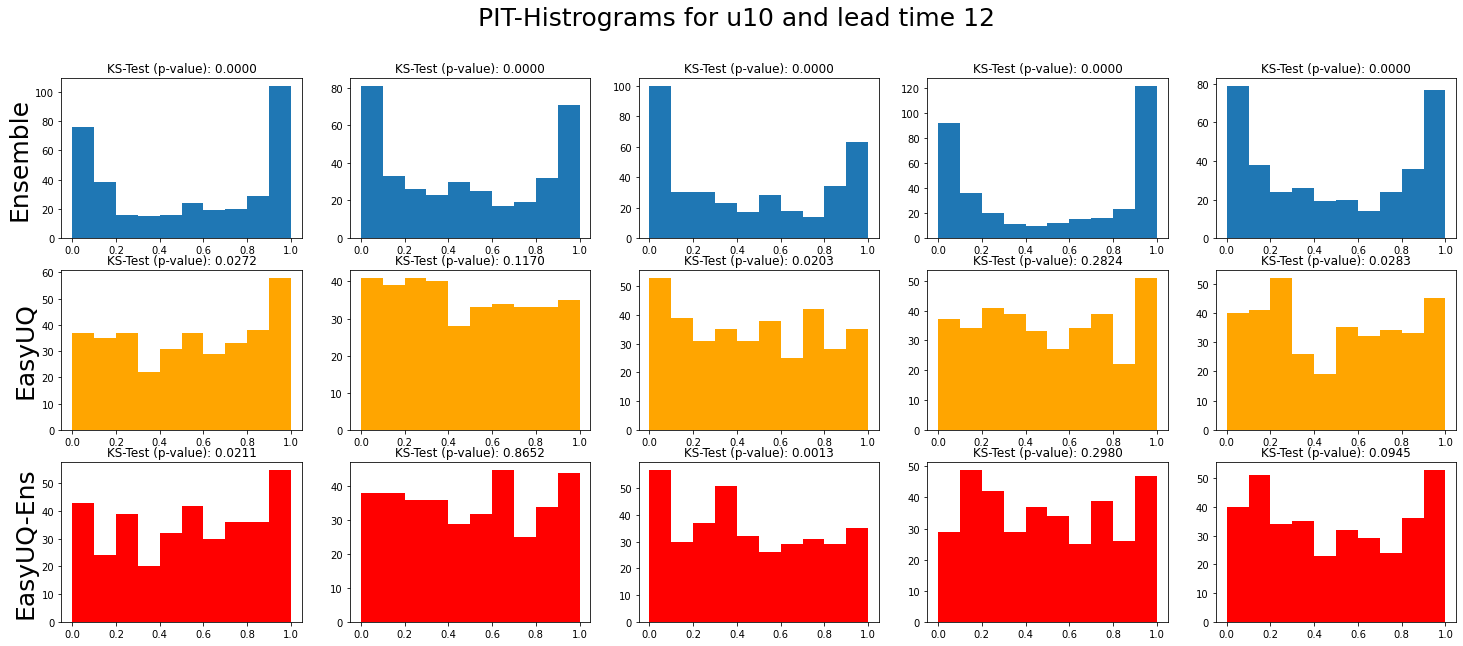

In [32]:
get_pit_plot(12, "u10")

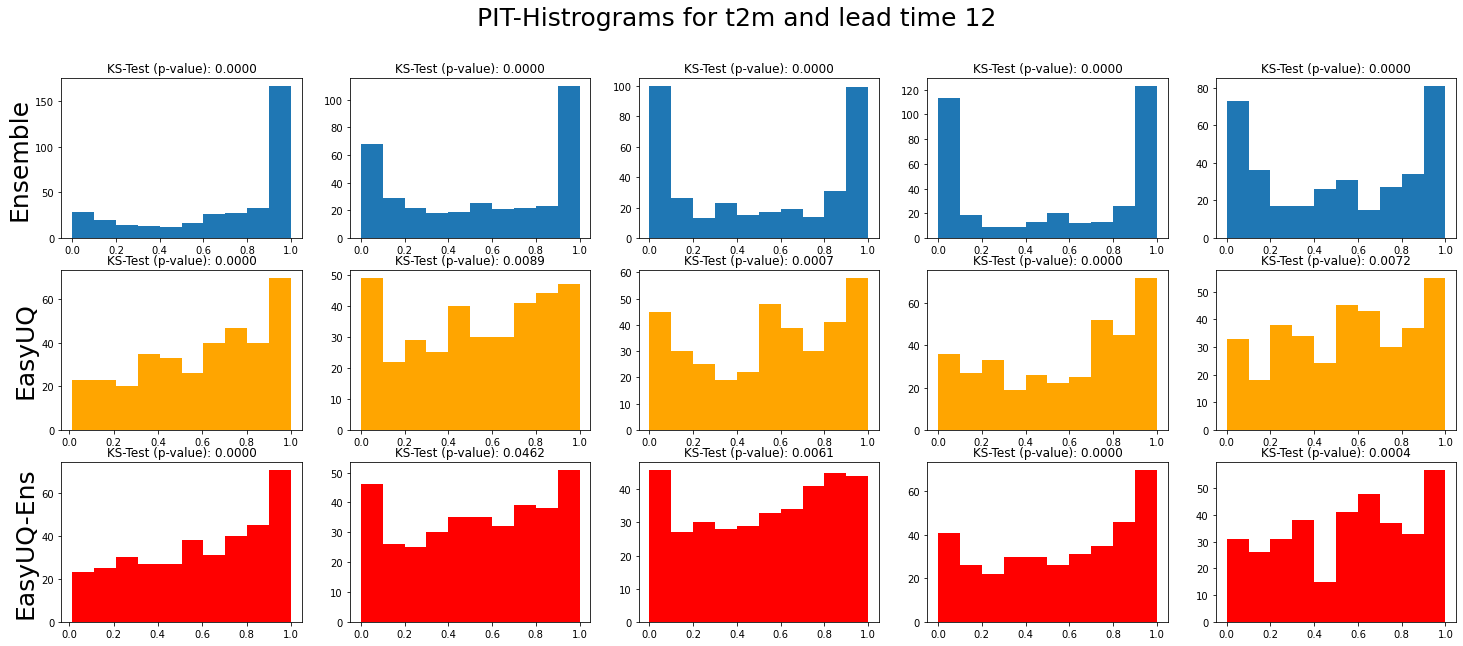

In [33]:
get_pit_plot(12, "t2m")

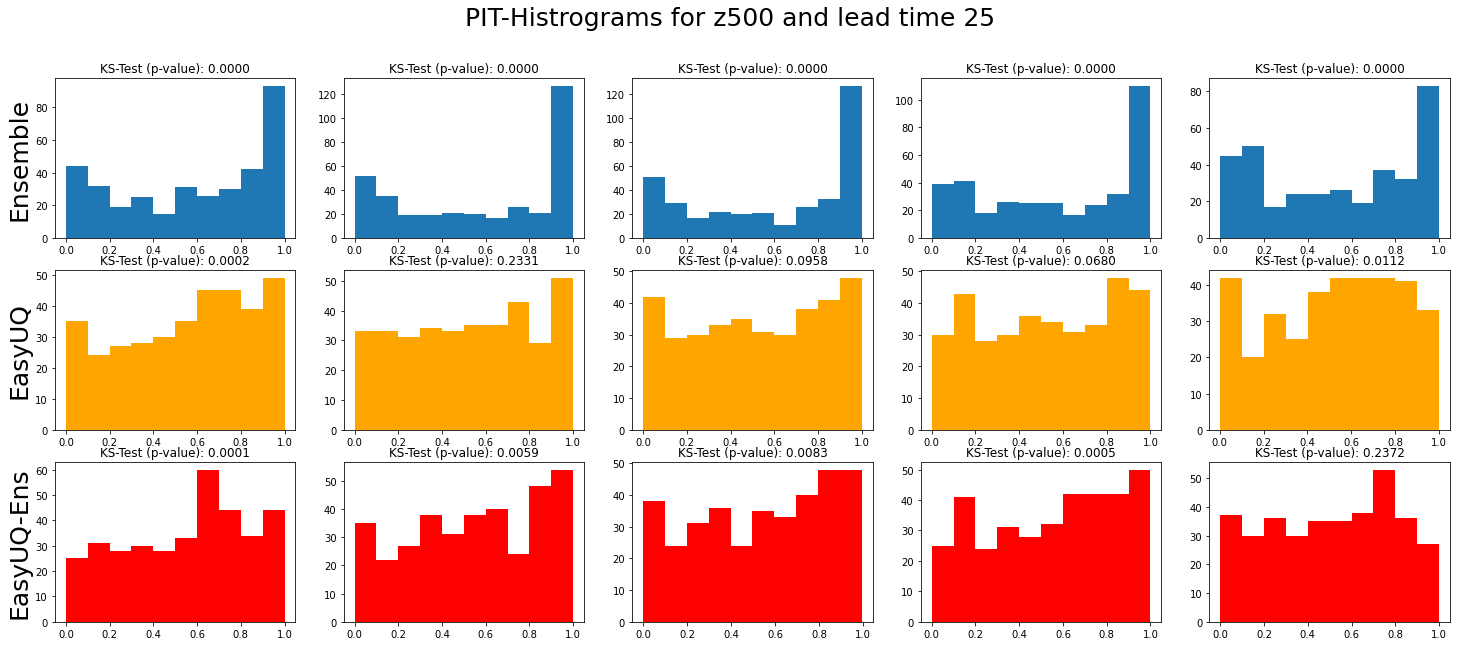

In [34]:
get_pit_plot(25, "z500")